### Select specific event to deconvolve and output all the fun plots

In [1]:
import sys,os,os.path
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs
from matplotlib.lines import Line2D


import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

def collect_min_max_bins(hits):
    '''
    returns all the min, max and mid values you'd need
    as well as the bins
    '''
    x_range = (hits.X.max()-hits.X.min())/2.
    y_range = (hits.Y.max()-hits.Y.min())/2.
    z_range = (hits.Z.max()-hits.Z.min())/2.
    mid_x   = (hits.X.max()+hits.X.min())/2.
    mid_y   = (hits.Y.max()+hits.Y.min())/2.
    mid_z   = (hits.Z.max()+hits.Z.min())/2.
    min_x = hits.X.min()
    min_y = hits.Y.min()
    min_z = hits.Z.min()

    max_x = hits.X.max()
    max_y = hits.Y.max()
    max_z = hits.Z.max()
    #print("X maximum and minimum")
    #print(max_x, min_x)
    #print("")

    #print("Y maximum and minimum")
    #print(max_y, min_y)
    #print("")

    #print("Z maximum and minimum")
    #print(max_z, min_z)

    xbins = int(hits.X.max()-hits.X.min())
    ybins = int(hits.Y.max()-hits.Y.min())
    zbins = int((hits.Z.max()-hits.Z.min())/2.)
    
    array = [x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins]
    
    return (array)



def count_tracks_mc(hits_deco):
   
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.x
    ys = hits_deco.y
    zs = hits_deco.z
    es = hits_deco.energy

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no    

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")


def count_tracks(hits_deco):
    
    
    
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.X
    ys = hits_deco.Y
    zs = hits_deco.Z
    es = hits_deco.E

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no

In [2]:
# load in the exclusively signal sophronia events here
base_dir = '/gluster/data/next/notebooks/john_books/soph_df_data/'
soph_file = base_dir + 'Tl_signal_soph.h5'
soph_MC =   base_dir + 'Tl_signal_true_info.h5'
soph_hdst = pd.read_hdf(soph_file)#CHITS/lowTh

In [3]:
soph_MC_hits = pd.read_hdf(soph_MC)

In [4]:
display(soph_hdst)
display(soph_MC_hits)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
4464,16,1.719597e+07,0,294.950939,190.401386,1,303.225,194.375,0.0,0.0,730.640203,6.666667,555.411165,-1.0,0.001900,-1,-1.0
4465,16,1.719597e+07,0,294.950939,190.401386,1,303.225,209.925,0.0,0.0,730.640203,5.797101,482.966206,-1.0,0.001653,-1,-1.0
4466,16,1.719597e+07,0,294.950939,190.401386,1,318.775,194.375,0.0,0.0,730.640203,9.159420,763.086640,-1.0,0.002611,-1,-1.0
4467,16,1.719597e+07,0,294.950939,190.401386,1,318.775,209.925,0.0,0.0,730.640203,7.014493,584.389133,-1.0,0.002000,-1,-1.0
4468,16,1.719597e+07,0,294.950939,190.401386,1,318.775,225.475,0.0,0.0,730.640203,5.913043,492.625569,-1.0,0.001694,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127144,5800580,5.800581e+12,0,106.308278,101.721715,1,132.175,116.625,0.0,0.0,624.912488,7.826087,282.545951,-1.0,0.000906,-1,-1.0
127145,5800580,5.800581e+12,0,106.308278,101.721715,1,101.075,101.075,0.0,0.0,627.939966,6.840580,602.885083,-1.0,0.001922,-1,-1.0
127146,5800580,5.800581e+12,0,106.308278,101.721715,1,132.175,85.525,0.0,0.0,627.939966,4.000000,352.534483,-1.0,0.001122,-1,-1.0
127147,5800580,5.800581e+12,0,106.308278,101.721715,1,132.175,101.075,0.0,0.0,627.939966,4.869565,429.172396,-1.0,0.001376,-1,-1.0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
3236,8,52,0,315.166870,208.526917,731.868896,1.128019,0.000005,ACTIVE
3237,8,51,0,315.680695,208.035660,732.565308,0.961651,0.001719,ACTIVE
3238,8,51,1,316.120941,207.520065,733.248108,0.965438,0.001694,ACTIVE
3239,8,51,2,316.652252,206.863007,733.708008,0.969227,0.000674,ACTIVE
3240,8,51,3,316.177185,206.028381,733.763306,0.973017,0.004037,ACTIVE
...,...,...,...,...,...,...,...,...,...
100291,2900290,45,30,112.188820,95.269257,618.456299,1.479308,0.000619,ACTIVE
100292,2900290,45,31,112.198914,95.268547,618.448975,1.479575,0.001096,ACTIVE
100293,2900290,45,32,112.202179,95.277473,618.447754,1.479800,0.002352,ACTIVE
100294,2900290,45,33,112.203796,95.279572,618.450989,1.479932,0.001731,ACTIVE


In [14]:
# now deconvolve specific events
evt = 300152
hits_of_int = soph_hdst[soph_hdst.event == evt]
MC_hits_of_int = soph_MC_hits[soph_MC_hits.event_id == evt/2]

In [15]:
thresh = 4

# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = '/gluster/data/next/software/IC_satkill/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 75,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 50,                       # after how many iterations do you start scanning? 
                  satellite_dist  = 2,                        # how far away do two clouds have to be to be considered unique
                  satellite_size  = 10,                       # maximum size of satellites, beyond which they are considered signal.
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [16]:
hits_cut = coref.timefunc(cut_sensors)(hits_of_int.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.026466846466064453 s
Time spent in drop_isolated: 0.04594588279724121 s


In [20]:
# set satellite iter here
deconv_params_['satellite_iter']  = 25

# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']

deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)


hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())


Time spent in apply_deconvolution: 9.520589351654053 s


Text(0.5, 0.98, '3D_deconvolved_300152_satkill_iteration 25')

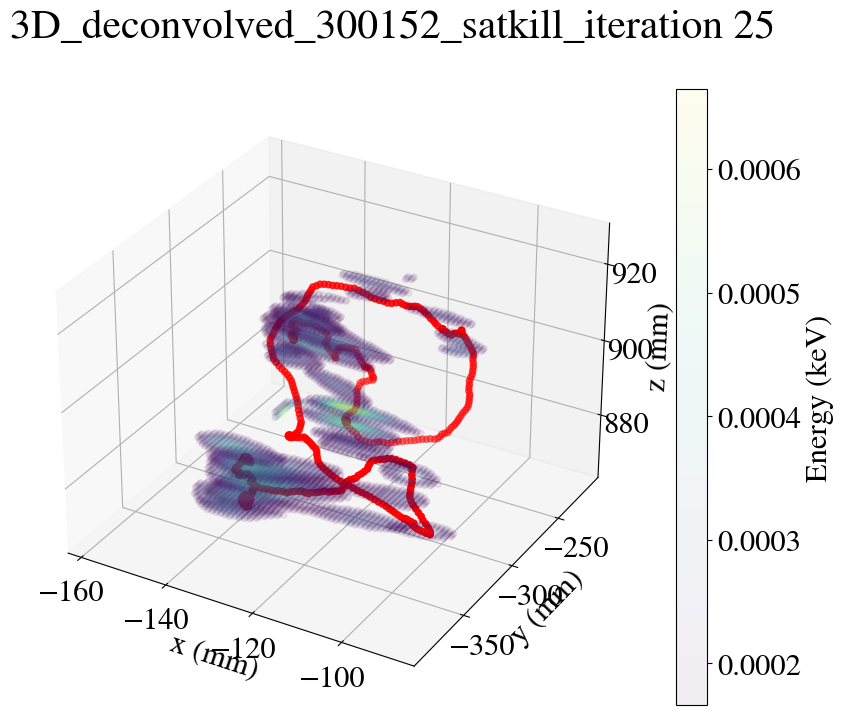

In [21]:

x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E

xtMC = MC_hits_of_int.x
ytMC = MC_hits_of_int.y
ztMC = MC_hits_of_int.z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=e, alpha = 0.07, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.scatter(xtMC, ytMC, ztMC, color='red')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_' + str(int(evt)) + "_satkill_iteration " + str(deconv_params_['satellite_iter']), fontsize=30)

3


/tmp/ipykernel_1252834/1363641268.py:74: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


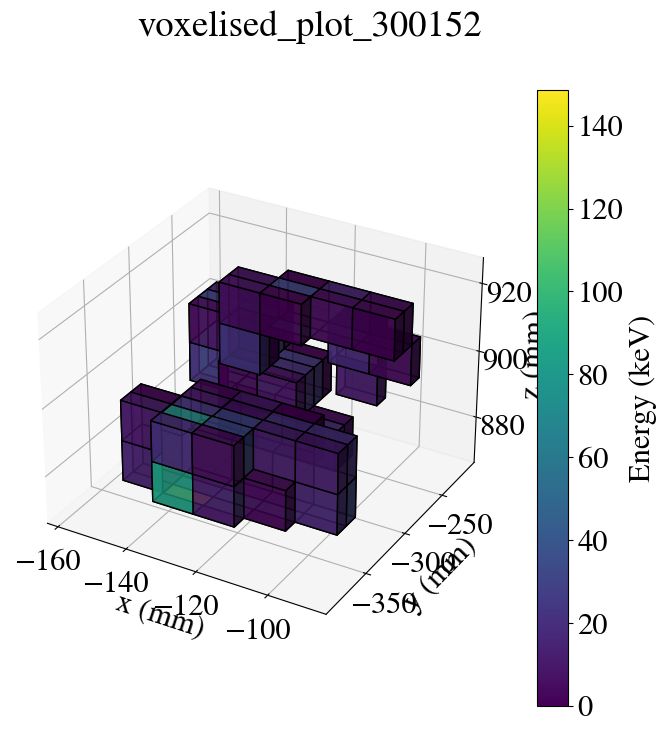

In [22]:
# stuff needed for paolina track counting
energy_threshold = 10
min_voxels = 3
    

base_vsize = 12 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

(voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)


tracks = make_track_graphs(voxels)
tracks = sorted(tracks, key=get_track_energy, reverse = True)

track_no = 0
for c, t in enumerate(tracks, 0):
    track_no += 1

print(track_no)
# drop voxels below certain energy

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + str(evt))
plt.show()